In [244]:
# Carregando libs necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns


import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras.layers import Dropout

from time import time_ns
import random
import keras

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

In [245]:
# The function is defined with default parameters so that if you call it with just your data, it will construct a DataFrame with t-1 
# as X and t as y

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [246]:
###########################################################
# file_name = "/content/Base_Volve_Pocos.xlsx" # File name
file_name = "Base_Volve_Pocos.xlsx" # File name
###########################################################

#MELHOR PARA TREINAR E FICAR BOM: 'NO15-9-F-1-C'>'NO15-9-F-15-D' -> Esse cara vai muito para zero
# BOM MAS COM PERFIL SHIFITADO 'NO15-9-F-11-H'~=~'NO15-9-F-12-H'#
sheet_name ='NO15-9-F-1-C' #'NO15-9-F-12-H'# 'NO15-9-F-14-H'#'NO15-9-F-15-D'#'NO15-9-F-11-H'#'NO15-9-F-12-H'#'NO15-9-F-11-H'# 4th sheet
header = 0 # The header is the 2nd row
df_full = pd.read_excel(file_name, sheet_name = sheet_name, header = header)
df_full.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


In [247]:
df_filter=df_full[df_full['WELL_TYPE'] != 'WI']
df_filter.isna().sum()
target = df_filter[['BORE_OIL_VOL','BORE_WAT_VOL','BORE_GAS_VOL','AVG_WHP_P','AVG_WHT_P']]

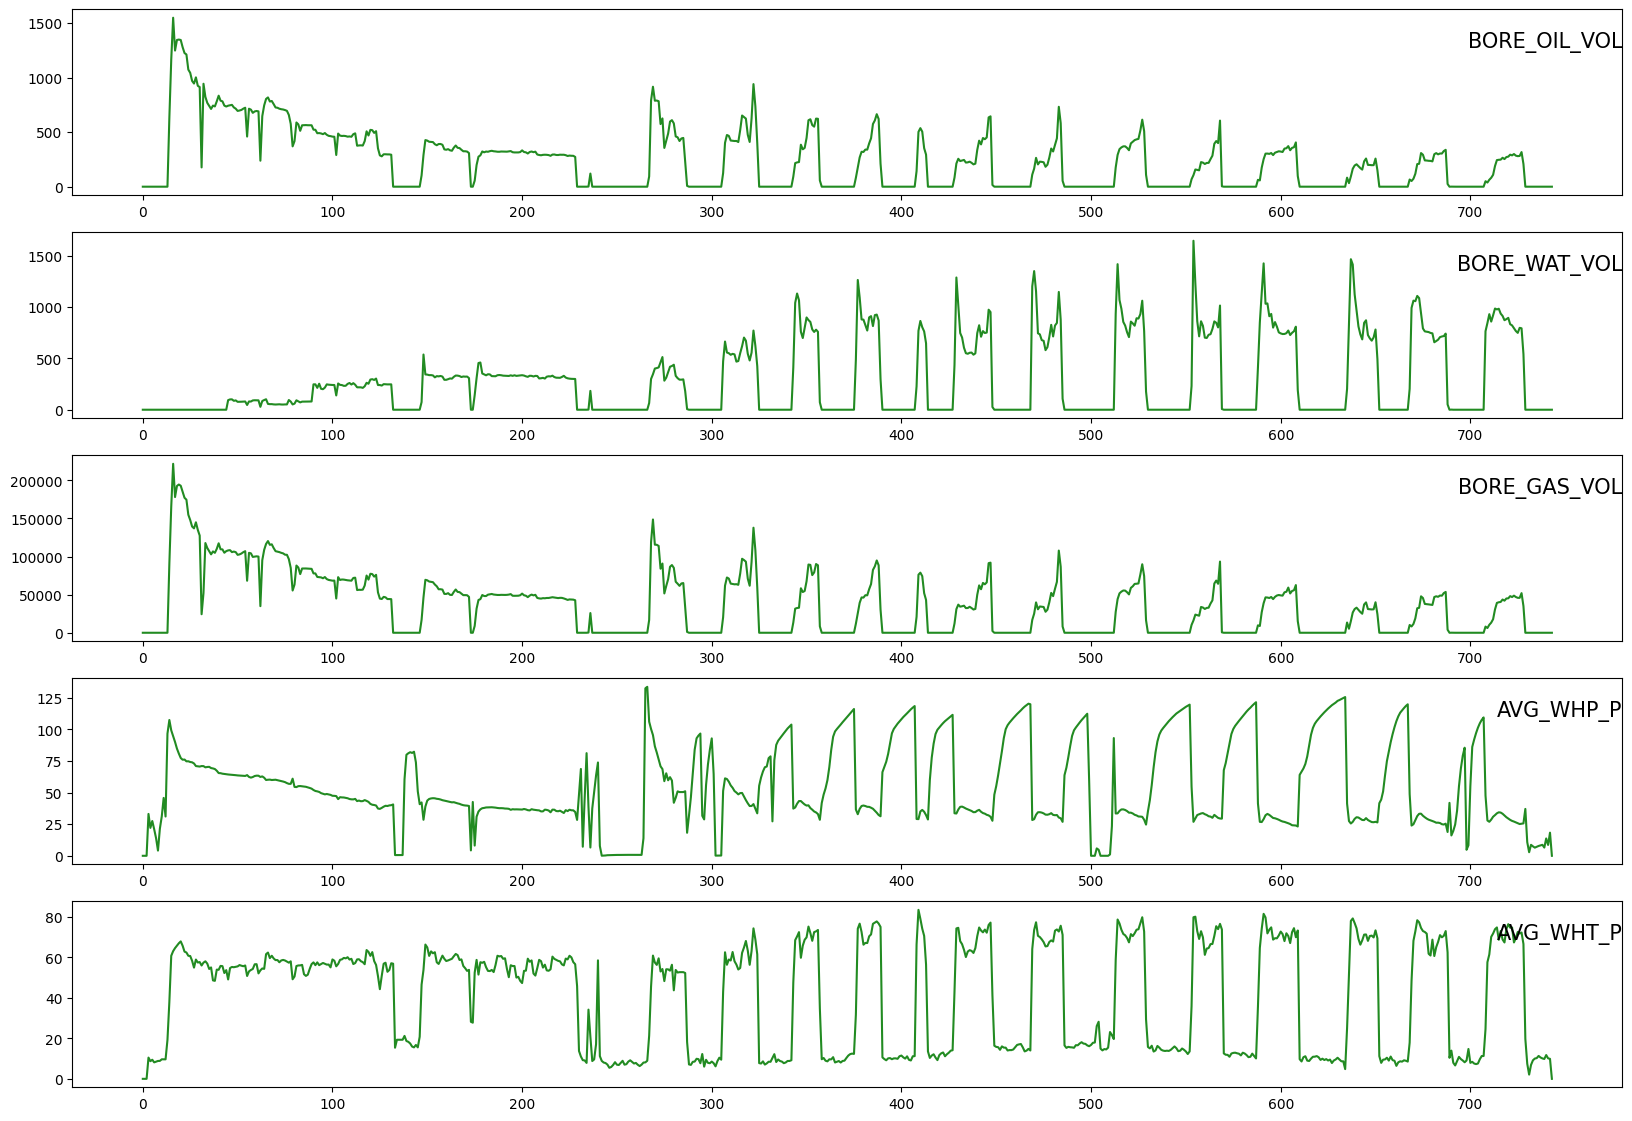

In [248]:
values = target.values

# specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1

# plot each column
plt.figure(figsize=(20,14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], c = "forestgreen")
    plt.title(target.columns[group], y=0.75, loc='right', fontsize = 15)
    i += 1
plt.show()

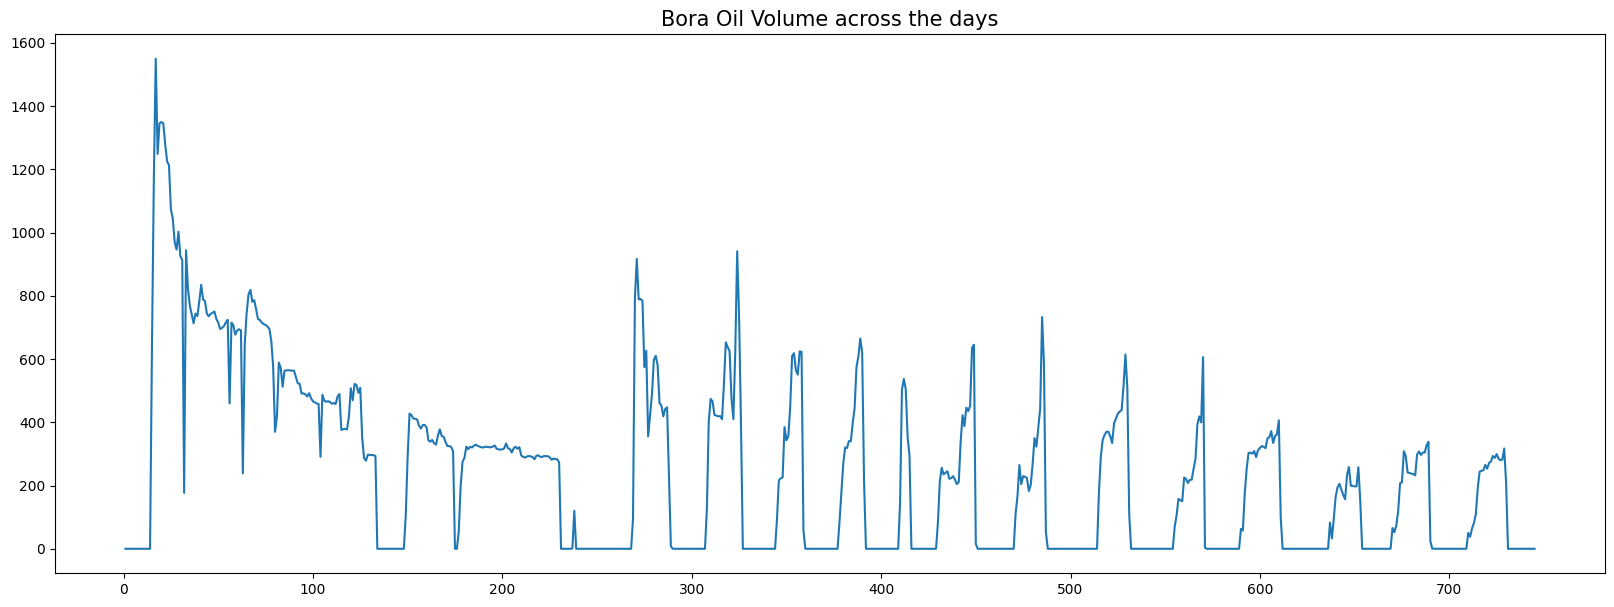

In [249]:
fig = plt.figure(figsize = (20,7))
plt.plot(target.BORE_OIL_VOL)
plt.title("Bora Oil Volume across the days", fontsize = 15)
plt.show()

<Axes: >

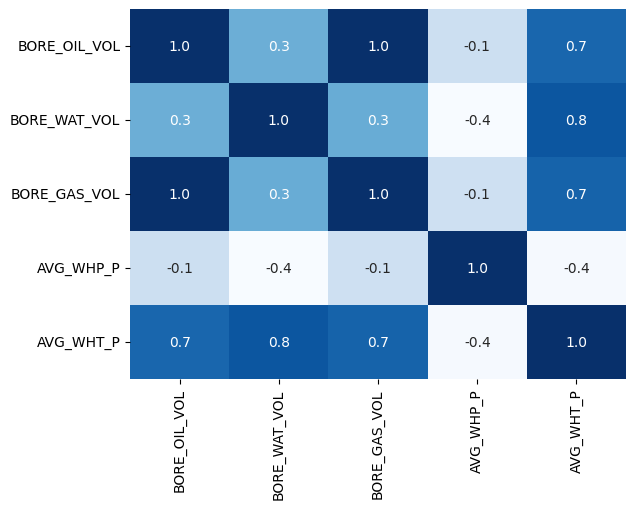

In [250]:
sns.heatmap(target.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

In [251]:
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [252]:
# Scaling the entire dataset

dataset = target
values = dataset.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [253]:
# converting the dataset as supervised learning

reframed = series_to_supervised(scaled, 4, 1) # 7,10 ficou horrivel # Ficou melhorzinho 4>5>1>3>2
print(reframed.shape)

(740, 25)


In [254]:
print(reframed.head())

   var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var1(t-3)   
4        0.0        0.0        0.0   0.000000   0.000000        0.0  \
5        0.0        0.0        0.0   0.000000   0.000000        0.0   
6        0.0        0.0        0.0   0.000000   0.000000        0.0   
7        0.0        0.0        0.0   0.247753   0.125628        0.0   
8        0.0        0.0        0.0   0.165079   0.104342        0.0   

   var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  ...  var1(t-1)  var2(t-1)   
4        0.0        0.0   0.000000   0.000000  ...        0.0        0.0  \
5        0.0        0.0   0.000000   0.000000  ...        0.0        0.0   
6        0.0        0.0   0.247753   0.125628  ...        0.0        0.0   
7        0.0        0.0   0.165079   0.104342  ...        0.0        0.0   
8        0.0        0.0   0.205871   0.112960  ...        0.0        0.0   

   var3(t-1)  var4(t-1)  var5(t-1)  var1(t)  var2(t)  var3(t)   var4(t)   
4        0.0   0.247753   0.125628      0

In [255]:
target.head()

,BORE_OIL_VOL,BORE_WAT_VOL,BORE_GAS_VOL,AVG_WHP_P,AVG_WHT_P
1,0.0,0.0,0.0,0.00000,0.00000
2,0.0,0.0,0.0,0.00000,0.00000
3,0.0,0.0,0.0,0.00000,0.00000
4,0.0,0.0,0.0,33.09788,10.47992
5,0.0,0.0,0.0,22.05334,8.70429


In [256]:
reframed.columns

Index(['var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)', 'var5(t-4)',
       'var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var5(t-3)',
       'var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)',
       'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)'],
      dtype='object')

In [257]:
# droping columns we don't want to predict

# reframed.drop(reframed.columns[[6, 7, 8, 9 ]], axis=1, inplace=True)
columns_to_drop = ['var2(t)', 'var3(t)', 'var4(t)', 'var5(t)']
reframed.drop(columns_to_drop, axis=1, inplace=True)
print(reframed.head())

   var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var1(t-3)   
4        0.0        0.0        0.0   0.000000   0.000000        0.0  \
5        0.0        0.0        0.0   0.000000   0.000000        0.0   
6        0.0        0.0        0.0   0.000000   0.000000        0.0   
7        0.0        0.0        0.0   0.247753   0.125628        0.0   
8        0.0        0.0        0.0   0.165079   0.104342        0.0   

   var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  ...  var2(t-2)  var3(t-2)   
4        0.0        0.0   0.000000   0.000000  ...        0.0        0.0  \
5        0.0        0.0   0.000000   0.000000  ...        0.0        0.0   
6        0.0        0.0   0.247753   0.125628  ...        0.0        0.0   
7        0.0        0.0   0.165079   0.104342  ...        0.0        0.0   
8        0.0        0.0   0.205871   0.112960  ...        0.0        0.0   

   var4(t-2)  var5(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   
4   0.000000   0.000000        0.0        0.0

In [258]:
train_ratio = 0.8

# Split the dataset into train and test sets
split_index = int(len(target) * train_ratio)

In [259]:
values = reframed.values

# We train the model on the 1st 3 years and then test on the last year (for now)
n_train_hours = split_index

train = values[:split_index, :]
test = values[split_index:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(595, 1, 20) (595,) (145, 1, 20) (145,)


In [260]:
n_neurons = 50 # X_train.shape[1] * y_train.shape[1]
n_neurons

50

In [261]:
model_LSTM = Sequential()
model_LSTM.reset_states()
# model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim)))
model_LSTM.add(LSTM(n_neurons, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
model_LSTM.add(LSTM(n_neurons, return_sequences=True))
model_LSTM.add(LSTM(n_neurons, return_sequences=False))
model_LSTM.add(Dense(1))
model_LSTM.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [262]:
epochs = 300 # Choose the number of training epochs
batch_size = 1#5#10 # Choose the batch size for training

In [1]:
train_X.shape

NameError: name 'train_X' is not defined

In [263]:
# Train the model
history_LSTM = model_LSTM.fit(train_X, train_y, batch_size=batch_size, epochs=epochs)
train_loss_history_LSTM = history_LSTM.history['loss']

Epoch 1/300
595/595 [==============================] - 5s 5ms/step - loss: 0.0115 - mean_absolute_error: 0.0677
Epoch 2/300
595/595 [==============================] - 3s 5ms/step - loss: 0.0069 - mean_absolute_error: 0.0496
Epoch 3/300
595/595 [==============================] - 3s 5ms/step - loss: 0.0059 - mean_absolute_error: 0.0465
Epoch 4/300
595/595 [==============================] - 3s 5ms/step - loss: 0.0055 - mean_absolute_error: 0.0427
Epoch 5/300
595/595 [==============================] - 3s 5ms/step - loss: 0.0055 - mean_absolute_error: 0.0425
Epoch 6/300
595/595 [==============================] - 3s 5ms/step - loss: 0.0054 - mean_absolute_error: 0.0457
Epoch 7/300
595/595 [==============================] - 3s 5ms/step - loss: 0.0051 - mean_absolute_error: 0.0411
Epoch 8/300
595/595 [==============================] - 3s 5ms/step - loss: 0.0049 - mean_absolute_error: 0.0416
Epoch 9/300
595/595 [==============================] - 3s 5ms/step - loss: 0.0052 - mean_absolute_error:

In [264]:
testPredict = model_LSTM.predict(test_X)
print(testPredict.shape)
testPredict_scaled = testPredict.ravel()

print(testPredict_scaled.shape)

5/5 [==============================] - 1s 4ms/step
(145, 1)
(145,)


In [265]:
y_test_true_scaled = test_y

In [266]:
poll = np.array(target["BORE_OIL_VOL"])

meanop = poll.mean()
stdop = poll.std()

y_test_true = y_test_true_scaled * stdop + meanop
testPredict = testPredict_scaled * stdop + meanop

In [267]:
testPredict_scaled

array([ 2.07586199e-01,  2.24048615e-01,  2.27683246e-01,  2.22409040e-01,
        2.47010484e-01,  2.60449260e-01,  2.86480218e-01,  2.06213668e-01,
        2.71695435e-01,  2.73491085e-01,  2.88487583e-01, -2.32124329e-02,
        1.92129612e-03, -5.77121973e-04, -5.70890307e-03, -3.60354781e-03,
       -3.88687849e-03, -3.67006660e-03, -2.10371614e-03,  4.34219837e-05,
        1.38410926e-03,  2.35557556e-03,  2.90536880e-03,  3.27152014e-03,
        4.05910611e-03,  4.60118055e-03,  5.20685315e-03,  5.45254350e-03,
        5.99211454e-03,  6.09812140e-03,  6.92164898e-03,  7.36567378e-03,
        7.63940811e-03,  7.30529428e-03,  7.32952356e-03,  7.80376792e-03,
        7.83967972e-03,  8.26675594e-02,  1.07310474e-01,  1.39738724e-01,
        1.46468863e-01,  1.11916006e-01,  1.19207352e-01,  1.13798544e-01,
        1.14529967e-01,  1.14687890e-01,  1.76953420e-01,  1.82474405e-01,
        1.18237793e-01,  1.27802819e-01,  1.24260515e-01,  1.35929480e-01,
        1.82924777e-01,  

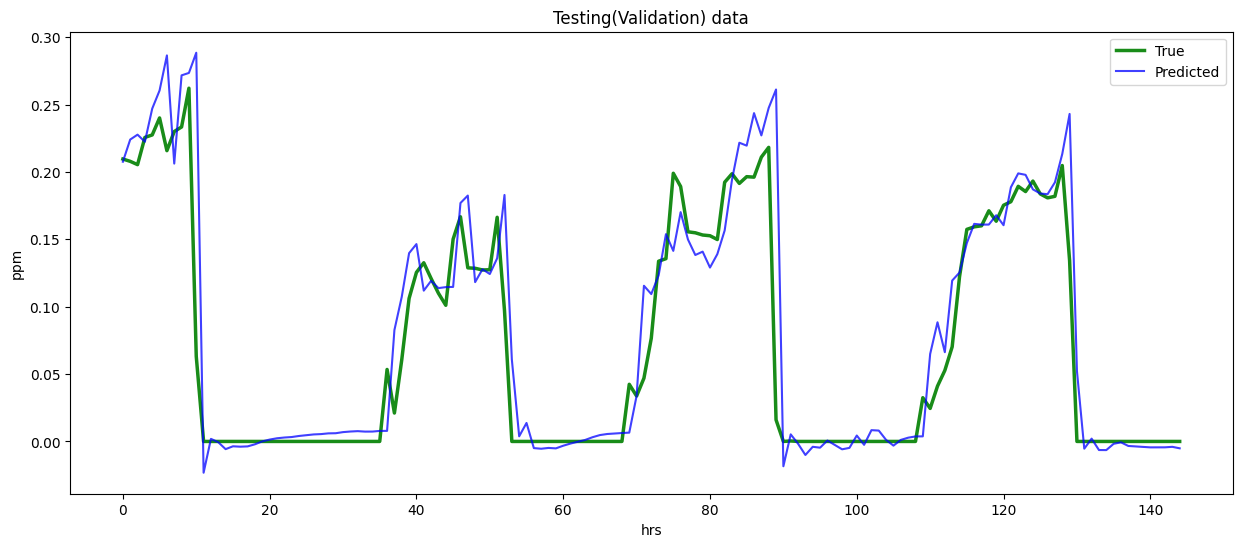

In [268]:
plt.figure(figsize=(15,6))
# plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true_scaled, c = "g", alpha = 0.90, linewidth = 2.5,label='True')
plt.plot(testPredict_scaled, c = "b", alpha = 0.75,label='Predicted')
plt.legend()
plt.title("Testing(Validation) data")
plt.show()

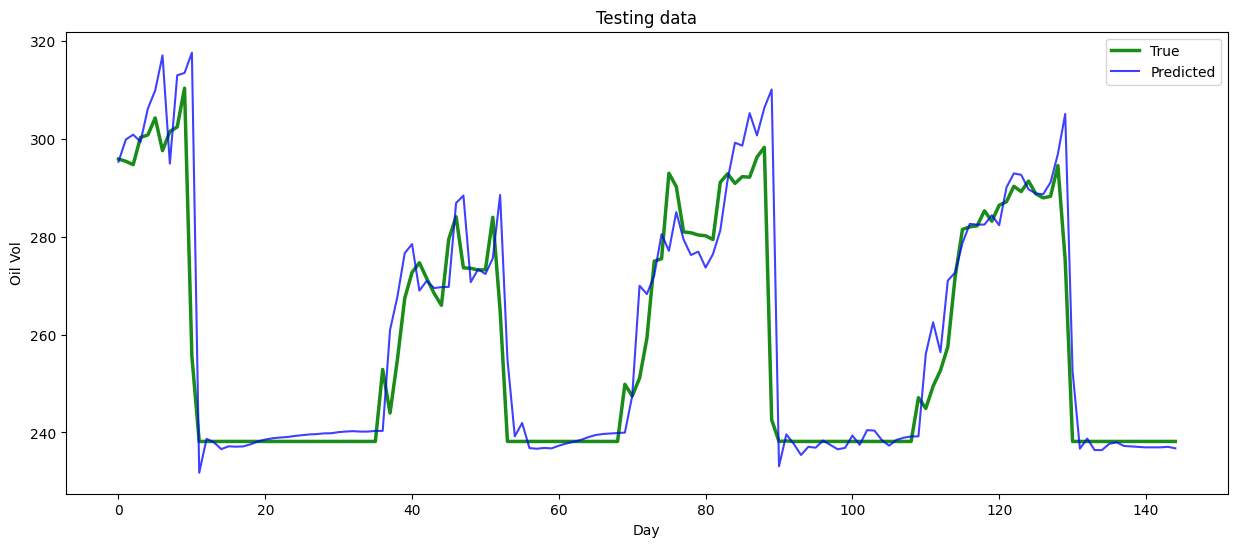

In [269]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
# plt.xlim([1000,1250])
plt.ylabel("Oil Vol")
plt.xlabel("Day")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5,label='True')
plt.plot(testPredict, c = "b", alpha = 0.75,label='Predicted')
plt.legend()
plt.title("Testing data")
plt.show()

In [270]:
rmse = np.sqrt(mean_squared_error(y_test_true_scaled, testPredict_scaled))
print("Test(Validation) RMSE ="  ,rmse)

Test(Validation) RMSE = 0.03621752
